In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Model building:

##### Setup the model parameters and inital conditions:
It is a good idea to use dictionaries for this, so when indexing you can index by name and not make mistakes by indexing the wrong number. In this setup, to preserve the correct order we must convert the dictionary values to a list by using the functions `params_for_sim` and `init_for_sim` before using them in simulations. When we want to change a parameter or initial condition we can copy the dictionary (`dict_copy = params_dict.copy()`), access and change a single variable by `dict_copy['s0'] = 100`, before converting it back to a list (`params = params_for_sim(dict_copy)`) for simulation. 

In [21]:
params_dict = {
    'dm': 0.1,
    'kb': 1,
    'ku': 1.0,
    'thetar': 426.8693338968694,
    's0': 1e4,
    'gmax': 1260.0,
    'thetax': 4.379733394834643,
    'Kt': 1.0e3,
    'M': 1.0e8,
    'we': 4.139172187824451,
    'Km': 1.0e3,
    'vm': 5800.0,
    'nx': 300.0,
    'Kq': 1.522190403737490e+05,
    'vt': 726.0,
    'wr': 929.9678874564831,
    'wq': 948.9349882947897,
    'nq': 4,
    'nr': 7549.0,
    'ns': 0.5,
    'Kgamma': 7,
}

def params_for_sim(param_dict):
    if len(param_dict) == 21:
        order = ['dm', 'kb', 'ku', 'thetar', 's0', 'gmax', 'thetax', 'Kt', 'M', 'we', 'Km', 'vm', 'nx', 'Kq', 'vt', 'wr', 'wq', 'nq', 'nr', 'ns', 'Kgamma']
    elif len(param_dict) == 23:
        order = ['dm', 'kb', 'ku', 'thetar', 's0', 'gmax', 'thetax', 'Kt', 'M', 'we', 'Km', 'vm', 'nx', 'Kq', 'vt', 'wr', 'wq', 'nq', 'nr', 'ns', 'Kgamma', 'Cm', 'k_cm']
    else:
        raise ValueError("param_dict must have either 21 or 23 parameters.")
    

    return [param_dict[key] for key in order]

params = params_for_sim(params_dict)

init_dict = {
    'mt_0': 0.,
    'mm_0': 0.,
    'mq_0': 0.,
    'mr_0': 0.,
    'ct_0': 0.,
    'cm_0': 0.,
    'cq_0': 0.,
    'cr_0': 0.,
    'et_0': 0.,
    'em_0': 0.,
    'q_0': 0.,
    'r_0': 10.0,
    'si_0': 0.,
    'a_0':  1000.0,

}

def init_for_sim(init_dict):
    if len(init_dict) == 14:
        order = ['mt_0', 'mm_0', 'mq_0', 'mr_0', 'ct_0', 'cm_0', 'cq_0', 'cr_0', 'et_0', 'em_0', 'q_0', 'r_0', 'si_0', 'a_0']
    elif len(init_dict) == 18:
        order = ['mt_0', 'mm_0', 'mq_0', 'mr_0', 'ct_0', 'cm_0', 'cq_0', 'cr_0', 'et_0', 'em_0', 'q_0', 'r_0', 'si_0', 'a_0', 'zmt_0', 'zmm_0', 'zmq_0', 'zmr_0']
    else:
        raise ValueError("init_dict must have either 14 or 18 variables.")
    
    return [init_dict[key] for key in order]

init = init_for_sim(init_dict)

##### We need to build the system of ODEs. Here are the reactions in the model:


![alt text](./growth_model.png "Reactions")

#### Transcription rate:

#### $\omega_x(a) = \omega_x \frac{a}{\theta_x + a}, \quad x \in {r,t,m}$

#### $\omega_q(q,a) = \omega_q \frac{a}{\theta_x + a} \frac{1}{1+(q/K_q)^{h_q}}$

#### Translation rate:

#### $c_x \frac{\gamma(a)}{n_x}, \quad \mathrm{where} \quad \gamma(a) = \frac{\gamma_{max} a}{K_{\gamma} + a}$

#### Growth rate:

#### $\lambda = \frac{\gamma(a) (c_r + c_t + c_m + c_q)}{M}$


For readability in the code it's good practise to build functions for the reaction rates:

In [12]:
# degradation
def deg(x, dm):
    return x * dm

# ribosome binding
def r_b(mx, r, kb):
    return kb * mx * r  

# ribosome unbinding
def r_ub(cx, ku):
    return cx * ku

# transcription rate
def tx(w, theta, a, q=None, Kq=None, nq=None): 
    if q is not None and Kq is not None and nq is not None:
        return (w * a / (theta + a)) / (1 + (q / (Kq )) ** nq)
    else:
        return w * a / (theta + a)

# translation rate
def tlr(a, nx, cx, gmax, Kgamma):
    gamma = gmax * a / (Kgamma + a) 
    return (gamma / nx) * cx

# energy consumption
def ttrate(a, cr, ct, cm, cq, gmax, Kgamma):
    gamma = gmax * a / (Kgamma + a)
    return (cr + ct + cm + cq) * gamma

# import 
def vimp(et, vt, s0, Kt):
    return et * vt * s0 / (Kt + s0)

# metabolism
def vcat(em, si, vm, Km):
    return em * vm * si / (Km + si)

# growth rate
def lam(a, cr, ct, cm, cq, gmax, Kgamma, M):
    gamma = gmax * a / (Kgamma + a)
    ttrate = (cr + ct + cm + cq) * gamma
    lam = ttrate / M
    return lam

We can start building the model, by adding reactions one step at a time. In Python, the model is defined in a function which must state the parameters, species (left hand side of ODE) and right hand side of ODE:

In [13]:
def model(t, y, params):
    # parameters
    dm, kb, ku, thetar, s0, gmax, thetax, Kt, M, we, Km, vm, nx, Kq, vt, wr, wq, nq, nr, ns, Kgamma = params

    # species (LHS)
    mt, mm, mq, mr, ct, cm, cq, cr, et, em, q, r, si, a = y
    
    # RHS of ODE
    dydt = np.zeros(14) # the order of the RHS will match the order of species in y eg. dydt[0] = dmt/dt, dydt[1] = dmm/dt, dydt[2] = dmq/dt etc.
    dmtdt, dmmdt, dmqdt, dmrdt, dctdt, dcmdt, dcqdt, dcrdt, detdt, demdt, dqdt, drdt, dsidt, dadt = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

    # Now go through each reaction and add its contribution to the appropriate species in dydt
    # transcription
    dmtdt += tx(we, thetax, a)
    dmmdt += tx(we, thetax, a)
    dmqdt += tx(wq, thetax, a, q=q, Kq=Kq, nq=nq)
    dmrdt += tx(wr, thetar, a)

    # mRNA degradation 
    dmtdt -= deg(mt, dm)
    dmmdt -= deg(mm, dm)
    dmqdt -= deg(mq, dm)
    dmrdt -= deg(mr, dm)

    # ribosome binding
    dmtdt -= r_b(mt, r, kb)
    dmmdt -= r_b(mm, r, kb)
    dmqdt -= r_b(mq, r, kb)
    dmrdt -= r_b(mr, r, kb)

    dctdt += r_b(mt, r, kb)
    dcmdt += r_b(mm, r, kb)
    dcqdt += r_b(mq, r, kb)
    dcrdt += r_b(mr, r, kb)

    drdt =  - r_b(mt, r, kb) - r_b(mm, r, kb) - r_b(mq, r, kb) - r_b(mr, r, kb)

    # ribosome unbinding 
    dmtdt += r_ub(ct, ku)
    dmmdt += r_ub(cm, ku)
    dmqdt += r_ub(cq, ku)
    dmrdt += r_ub(cr, ku)

    dctdt -= r_ub(ct, ku)
    dcmdt -= r_ub(cm, ku)
    dcqdt -= r_ub(cq, ku)
    dcrdt -= r_ub(cr, ku)

    drdt += r_ub(ct, ku) + r_ub(cm, ku) + r_ub(cq, ku) + r_ub(cr, ku)

    # translation
    dmtdt += tlr(a, nx, ct, gmax, Kgamma)
    dmmdt += tlr(a, nx, cm, gmax, Kgamma)
    dmqdt += tlr(a, nx, cq, gmax, Kgamma)
    dmrdt += tlr(a, nr, cr, gmax, Kgamma)

    dctdt -= tlr(a, nx, ct, gmax, Kgamma)
    dcmdt -= tlr(a, nx, cm, gmax, Kgamma)
    dcqdt -= tlr(a, nx, cq, gmax, Kgamma)
    dcrdt -= tlr(a, nr, cr, gmax, Kgamma)

    detdt += tlr(a, nx, ct, gmax, Kgamma)
    demdt += tlr(a, nx, cm, gmax, Kgamma)
    dqdt += tlr(a, nx, cq, gmax, Kgamma)
    drdt += tlr(a, nr, cr, gmax, Kgamma) + tlr(a, nr, cr, gmax, Kgamma) + tlr(a, nx, ct, gmax, Kgamma) + tlr(a, nx, cm, gmax, Kgamma) + tlr(a, nx, cq, gmax, Kgamma)

    # nutrient import
    dsidt += vimp(et, vt, s0, Kt)

    # metabolism
    dsidt -= vcat(em, si, vm, Km)
    dadt += (ns*vcat(em, si, vm, Km))

    # energy consumption
    dadt -= ttrate(a, cr, ct, cm, cq, gmax, Kgamma)

    # dilution by growth 
    dmtdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mt)
    dmmdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mm)
    dmqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mq)
    dmrdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mr)

    dctdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * ct)   
    dcmdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cm)   
    dcqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cq)
    dcrdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cr)

    detdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * et)
    demdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * em)
    dqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * q)
    drdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * r)

    dsidt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * si)
    dadt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * a)

    # build full dydt system
    dydt[0] = dmtdt
    dydt[1] = dmmdt
    dydt[2] = dmqdt
    dydt[3] = dmrdt
    dydt[4] = dctdt
    dydt[5] = dcmdt
    dydt[6] = dcqdt
    dydt[7] = dcrdt
    dydt[8] = detdt
    dydt[9] = demdt
    dydt[10] = dqdt
    dydt[11] = drdt
    dydt[12] = dsidt
    dydt[13] = dadt

    return dydt

Set the timespan for the model to run to ensure it reaches steady state:

In [14]:
t0 = 0; tf = 1e9

Solve the model using the solve_ivp function from scipy.

In [15]:
sol = solve_ivp(model, [t0, tf], init, args=(params,), method='Radau')

Plot the results by plotting each species over time on the same plot:

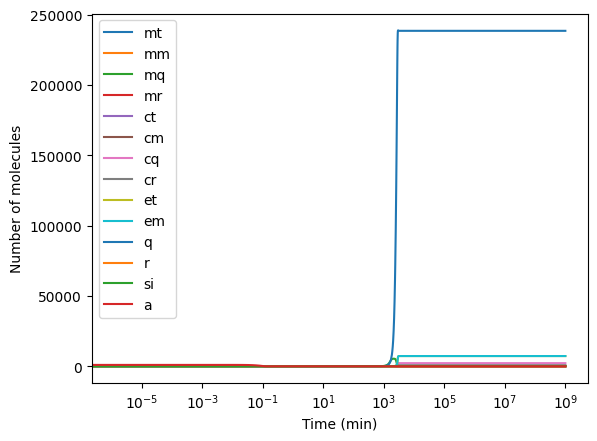

In [16]:
labels=['mt', 'mm', 'mq', 'mr', 'ct', 'cm', 'cq', 'cr', 'et', 'em', 'q', 'r', 'si', 'a']

for i in range(sol.y.shape[0]):
    plt.plot(sol.t, sol.y[i], label=labels[i])
    plt.xscale('log')
plt.xlabel('Time (min)')
plt.ylabel('Number of molecules')
plt.legend()

### Monod's law

Vary the nutrient (s0) and solve the model, calculate the growth rate and plot results:

Text(0.5, 1.0, "Monod's law")

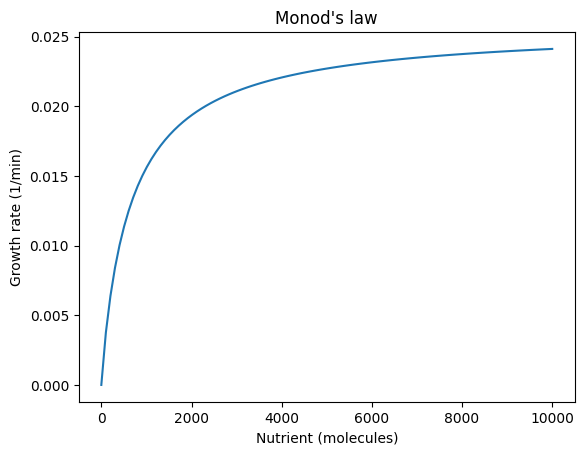

In [17]:
nutrient = np.linspace(0, 1e4, 100)
growth_rate = []
new_params_dict = params_dict.copy()

for i in nutrient:
    new_params_dict['s0'] = i
    params1 = params_for_sim(new_params_dict)
    sol = solve_ivp(model, [t0, tf], init, args=(params1,), method='Radau')
    mt, mm, mq, mr, ct, cm, cq, cr, et, em, q, r, si, a = sol.y
    growth_rate.append(lam(a[-1], cr[-1], ct[-1], cm[-1], cq[-1], new_params_dict['gmax'], new_params_dict['Kgamma'], new_params_dict['M']))

plt.plot(nutrient, growth_rate)
plt.xlabel('Nutrient (molecules)')
plt.ylabel('Growth rate (1/min)')
plt.title('Monod\'s law')

In [ ]:
# add nutrient growth law on its own 

#### As well as reproducing Monod's law, using this model we can also reproduce two other bacterial growth laws: the growth rate is linearly proportional to the ribosomal mass fraction (ΦR), and the addition of a translation-inhibtiing drug results in this relationship becoming negatively proportional

Include antibiotics in the original model by adding 4 zombie complexes, 1 for each protein sector, that consist of the drug bound to the ribosome-mRNA complex. Model building should be done as before, but this time you will have 17 species and one new reaction for antibiotic binding.

In [18]:
def abx_bind(cx, Cm, k_cm):
    return cx * Cm * k_cm

In [19]:
def abx_model(t, y, params):

    # parameters 
    dm, kb, ku, thetar, s0, gmax, thetax, Kt, M, we, Km, vm, nx, Kq, vt, wr, wq, nq, nr, ns, Kgamma, Cm, k_cm = params

    # species (LHS)
    mt, mm, mq, mr, ct, cm, cq, cr, et, em, q, r, si, a, zmt, zmm, zmq, zmr = y
    
    # RHS of ODE
    dydt = np.zeros(18) # the order of the RHS will match the order of species in y eg. dydt[0] = dmt/dt, dydt[1] = dmm/dt, dydt[2] = dmq/dt etc.

    # this model is just an extension of the previous one, so we will repeat the same steps with the addition of antibiotic binding 
    # transcription
    dmtdt = tx(we, thetax, a)
    dmmdt = tx(we, thetax, a)
    dmqdt = tx(wq, thetax, a, q=q, Kq=Kq, nq=nq)
    dmrdt = tx(wr, thetar, a)

    # mRNA degradation 
    dmtdt -= deg(mt, dm)
    dmmdt -= deg(mm, dm)
    dmqdt -= deg(mq, dm)
    dmrdt -= deg(mr, dm)

    # ribosome binding
    dmtdt -= r_b(mt, r, kb)
    dmmdt -= r_b(mm, r, kb)
    dmqdt -= r_b(mq, r, kb)
    dmrdt -= r_b(mr, r, kb)

    dctdt = r_b(mt, r, kb)
    dcmdt = r_b(mm, r, kb)
    dcqdt = r_b(mq, r, kb)
    dcrdt = r_b(mr, r, kb)

    drdt =  - r_b(mt, r, kb) - r_b(mm, r, kb) - r_b(mq, r, kb) - r_b(mr, r, kb)

    # ribosome unbinding 
    dmtdt += r_ub(ct, ku)
    dmmdt += r_ub(cm, ku)
    dmqdt += r_ub(cq, ku)
    dmrdt += r_ub(cr, ku)

    dctdt -= r_ub(ct, ku)
    dcmdt -= r_ub(cm, ku)
    dcqdt -= r_ub(cq, ku)
    dcrdt -= r_ub(cr, ku)

    drdt += r_ub(ct, ku) + r_ub(cm, ku) + r_ub(cq, ku) + r_ub(cr, ku)

    # translation
    dmtdt += tlr(a, nx, ct, gmax, Kgamma)
    dmmdt += tlr(a, nx, cm, gmax, Kgamma)
    dmqdt += tlr(a, nx, cq, gmax, Kgamma)
    dmrdt += tlr(a, nr, cr, gmax, Kgamma)

    dctdt -= tlr(a, nx, ct, gmax, Kgamma)
    dcmdt -= tlr(a, nx, cm, gmax, Kgamma)
    dcqdt -= tlr(a, nx, cq, gmax, Kgamma)
    dcrdt -= tlr(a, nr, cr, gmax, Kgamma)

    detdt = tlr(a, nx, ct, gmax, Kgamma)
    demdt = tlr(a, nx, cm, gmax, Kgamma)
    dqdt = tlr(a, nx, cq, gmax, Kgamma)
    drdt += tlr(a, nr, cr, gmax, Kgamma) + tlr(a, nr, cr, gmax, Kgamma) + tlr(a, nx, ct, gmax, Kgamma) + tlr(a, nx, cm, gmax, Kgamma) + tlr(a, nx, cq, gmax, Kgamma)

    # nutrient import
    dsidt = vimp(et, vt, s0, Kt)

    # metabolism
    dsidt -= vcat(em, si, vm, Km)
    dadt = (ns*vcat(em, si, vm, Km))

    # energy consumption
    dadt -= ttrate(a, cr, ct, cm, cq, gmax, Kgamma)

    # dilution by growth 
    dmtdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mt)
    dmmdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mm)
    dmqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mq)
    dmrdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mr)

    dctdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * ct)   
    dcmdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cm)   
    dcqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cq)
    dcrdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cr)

    detdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * et)
    demdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * em)
    dqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * q)
    drdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * r)

    dsidt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * si)
    dadt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * a)

    # antibiotic binding
    dctdt -= abx_bind(ct, Cm, k_cm)
    dcmdt -= abx_bind(cm, Cm, k_cm)
    dcqdt -= abx_bind(cq, Cm, k_cm)
    dcrdt -= abx_bind(cr, Cm, k_cm)

    dzmtdt = abx_bind(ct, Cm, k_cm)
    dzmmdt = abx_bind(cm, Cm, k_cm)
    dzmqdt = abx_bind(cq, Cm, k_cm)
    dzmrdt = abx_bind(cr, Cm, k_cm)

    # dilution for new zombie species
    dzmtdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * zmt)
    dzmmdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * zmm)
    dzmqdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * zmq)
    dzmrdt -= (lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * zmr)

    # build full dydt system
    dydt[0] = dmtdt
    dydt[1] = dmmdt
    dydt[2] = dmqdt
    dydt[3] = dmrdt
    dydt[4] = dctdt
    dydt[5] = dcmdt
    dydt[6] = dcqdt
    dydt[7] = dcrdt
    dydt[8] = detdt
    dydt[9] = demdt
    dydt[10] = dqdt
    dydt[11] = drdt
    dydt[12] = dsidt
    dydt[13] = dadt

    # new species
    dydt[14] = dzmtdt
    dydt[15] = dzmmdt
    dydt[16] = dzmqdt
    dydt[17] = dzmrdt


    return dydt

    

Define any new parameters and initial conditions:

In [22]:
params_abx_dict = params_dict.copy()
params_abx_dict['Cm'] = 0
params_abx_dict['k_cm'] = 0.005990373118888

init_abx_dict = init_dict.copy()
init_abx_dict['zmt_0'] = 0
init_abx_dict['zmm_0'] = 0
init_abx_dict['zmq_0'] = 0
init_abx_dict['zmr_0'] = 0

params_abx = params_for_sim(params_abx_dict)
init_abx = init_for_sim(init_abx_dict)

Define a function to calculate the ribosomal mass fraction:

In [23]:
def calc_rmf(r, cr, ct, cm, cq, zmr, zmt, zmm, zmq, nr, M):
    return nr * (r + cr + ct + cm + cq + zmr + zmt + zmm + zmq) / M

For different values of nutrient quality (ns) and chloramphenicol concentration (Cm) solve the model and calculate the associated growth rate and ribosomal mass fraction:

In [24]:
ns_arr2 = [0.08,0.11541599,0.16651064,0.24022489,0.3466,0.5]
Cm_arr = [0, 2, 4, 8, 12]
params_new_dict = params_abx_dict.copy()

gr_res = []
rmf_res = []
for i in ns_arr2:
    gr = []
    rmf = []
    params_new_dict['ns'] = i
    for j in Cm_arr:
        params_new_dict['Cm'] = j
        params_new = params_for_sim(params_new_dict)
        sol = solve_ivp(abx_model, [t0, tf], init_abx, args=(params_new,), method='Radau')
        mt, mm, mq, mr, ct, cm, cq, cr, et, em, q, r, si, a, zmt, zmm, zmq, zmr = sol.y
        gr.append(lam(a[-1], cr[-1], ct[-1], cm[-1], cq[-1], params_new_dict['gmax'], params_new_dict['Kgamma'], params_new_dict['M']))
        rmf.append(calc_rmf(r[-1], cr[-1], ct[-1], cm[-1], cq[-1], zmr[-1], zmt[-1], zmm[-1], zmq[-1], params_new_dict['nr'], params_new_dict['M']))
    gr_res.append(gr)
    rmf_res.append(rmf)

Text(0, 0.5, 'Ribosomal mass fraction')

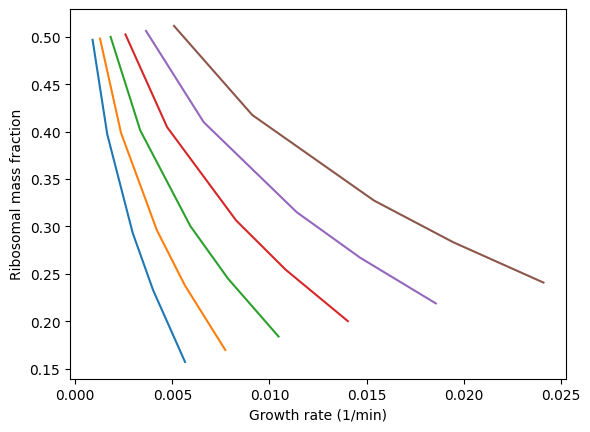

In [25]:
# plot the results 
for i in range(0,len(gr_res)):
  plt.plot(gr_res[i], rmf_res[i])

plt.xlabel('Growth rate (1/min)')
plt.ylabel('Ribosomal mass fraction')
